# Conditional density estimation of spatial fields 

## Summary

The `batram_cov` package provides simulators and a model for the conditional
density $p(y | x)$ of a high dimensional spatial field. The method can be
thought of as an extension to Katzfuss and Schafer (*JASA*, 2023)'s scalable
Bayesian transport map to account for the dependence of a vector of
covariates $x$. The Katzfuss and Schafer model exploited conjugacy
assumptions to optimize a closed form marginal likelihood $p_\theta(y)$ for
hyperparameters $\theta$. In our formulation we assume the same
autoregressive structure with a variational approximation
$$
    p(y | x) \equiv
    \prod_{i=1}^{N} p\big(y_i | f_i\{y_{c_i(m)}, x\},\, g_i\{x\}\big) q(f_i, g_i) =
    \prod_{i=1}^{N} \mathcal{N}\big(y_i | f_i\{y_{c_i(m)}, x\}, e^{g_i\{x\}} \big)\;
        \mathcal{N}\big(f_i | 0, K_i^{(f)}\big)\;
        \mathcal{N}\big(g_i | \mu_i, K_i^{(g)}\big),
$$
where $f$ and $g$ are given sparse (inducing point) Gaussian process priors.
Each of the regressions specified may be solved independently as a
heteroscedastic GP regression, making the model embarrassingly parallel and
easily trained using GPU architectures.

The inducing point Gaussian process regressions provide three important features:

1. Estimating problems where multiple fields $y_{1,j}, \dots, y_{n_j, j} |
x_j$ are observed. Many GP regression models would not allow this kind of
observation model.

2. Imposing low rank assumptions in the regression estimands.

3. Approximate UQ with scalable training.

Details of the model may be found in a forthcoming paper. This notebook
provides one demonstration of the method on a simulated training set.

In [1]:
# automatic reload
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from batram_cov import calc_li, gp
from batram_cov.model import (
    CovariateTransportMap,
    create_and_merge_problems,
    build_data_module,
)
from veccs import orderings

## Implementation details

`batram_cov` is implemented in
[JAX](https://docs.jax.dev/en/latest/quickstart.html), a purely functional
machine learning framework with extensive support for multi-device training
across CPU, GPU, and Google TPU architectures. Notable features of JAX are
its functional programming semantics (immutable arrays and management of
random number keys especially), its device management just mentioned, and its
powerful automatic differentiation library. Another important feature is its
speed: JAX code gets JIT compiled at runtime using Google's XLA compiler,
leading to highly optimized hardware instructions.

In [3]:
# NOTE: Configure jax to run with a cpu and some number of cores instead of using a gpu for fast prototyping
jax.config.update('jax_platform_name', 'cpu')

## Configuration

To demonstrate our method we are going to generate a dataset consisting of
Vecchia Gaussian processes using a Matern covariance function; this is a
special case of our model where the autoregression can be written strictly as
a linear transformation of the previous state, and the dependence on a
covariate is only in the parameterization of the covariance function.
Specifically, the density is
$$
    p(y | x) \equiv
    \prod_{i=1}^{N} p(y_i | y_{c_i(m)}(x) b(x), \sigma^2(x))
$$
for various values of $x = \log \nu$. Code to generate standard Gaussian
processes or Vecchia Gaussian processes are both provided in our package
under `batram_cov.gp`.

The constants in the next chunk can be modified to run the notebook with
different configurations from the one used. The greatest runtime differences
are attributable to `NLOCS`, which sets the number of gridded spatial values
to use on each side of a unit square. 

In [4]:
# NOTE: Global configs parameterizing the data generating process. These
# determine the size of the spatial grids and how many nearest neighbors to use
# when generating the Vecchia GPs. They can be modified to speed up the data
# generation and runtime of the notebook.
NLOCS = 16
NNS = 30
NUM_DATA_SAMPLES = 5
# Several code chunks depend on this staying hard coded. Modify it with caution.
XGRID = 100

In [5]:
@dataclass
class Data:
    locs: np.ndarray
    nearest_neighbors: np.ndarray
    li: np.ndarray
    maxmin_permutation: np.ndarray
    x: np.ndarray
    samples: np.ndarray

## Data generation

As said previously, we use the `batram.gp.VecchiaGP` model for data
generation. Here we generate `NLOCS x NLOCS` points on the unit square,
compute a maximin ordering of the points, find their nearest neighbors, and
supply these parameters to the generative model to build the Vecchia fields
we will test the model with. Katzfuss and Guinness (*Statistical Science*,
2021) provide more details on Vecchia fields which may be helpful to
understand this generating process. It may also be thought of as a standard
GP with a particular sparse precision matrix (based on the maximin ordering).

In [6]:
locs = gp.make_grid(NLOCS, 2)
maxmin_ordering = orderings.maxmin_cpp(locs)
nns = orderings.find_nns_l2(locs[maxmin_ordering], NNS)
x = np.linspace(np.log(0.25), np.log(4.5), XGRID)
nus = np.exp(x)

dgp = gp.VecchiaGP(locs=locs[maxmin_ordering], nbrs=nns, kernel=gp.kernel, seed=0)
y = np.empty((NUM_DATA_SAMPLES, x.size, locs.shape[0]))
for j, nu in enumerate(nus):
    y[:, j] = dgp.sample(n=y.shape[0], nu=nu, nugget=1e-6)[0]

# unsort the values for plotting in the next chunk
y = y[..., maxmin_ordering.argsort()]

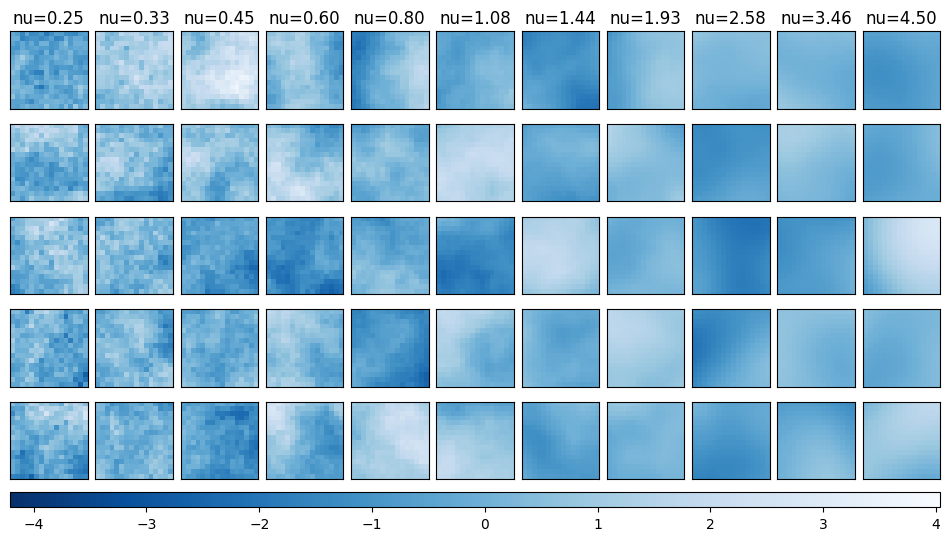

In [7]:
vmin, vmax = y.min(), y.max()

fig, ax = plt.subplots(
    5, 11, figsize=(12, 6), gridspec_kw={"wspace": 0.1, "hspace": 0.01}
)
for j, nu in enumerate(*np.c_[*nus[::10], nus[-1]]):
    ax[0, j].set_title(f"{nu=:.2f}")
    for i in range(5):
        y_idx = 10 * j if 10 * j < 100 else -1
        _ = ax[i, j].imshow(
            y[i, y_idx].reshape(NLOCS, NLOCS), cmap="Blues_r", vmin=vmin, vmax=vmax
        )
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])


cax = fig.add_axes([0.125, 0.075, 0.775, 0.025])
cbar = fig.colorbar(_, cax, orientation="horizontal")
plt.show()

## Train-validation splits

Next we will split the generated data into train and validation sets. There
are 100 fields to choose from, and we use 75 for training. The 25 fields used
for validation will be used for early stopping of the optimizer.

In [8]:
idx = set(range(XGRID))
train_idx = list(range(0, XGRID, 2))
train_idx.append(XGRID-1)
valid_idx = list(idx.difference(train_idx))

train_x = x[train_idx, None]
valid_x = x[valid_idx, None]

train_y = y[:1, train_idx]
valid_y = y[:1, valid_idx]

li = calc_li(locs[maxmin_ordering], nns)

The next step is to configure and instantiate the model. This requires
instantiating a `TMDataModule` for each dataset (this is done internally in
`create_and_merge_problems`) and then creating a `CovariateTransportMap`
using those objects. Recall here that JAX is a functional language requiring
explicit management of all state, including random number keys. The main
reason to use the `CovariateTransportMap` implementation is because it
manages RNG keys for you internally. If the RNG seed is not provided
explicitly then it is obtained from the system clock.

The `create_and_merge_problems` function defines the regression problems in
our method with several choices for parameter initialization and problem
configuration. We show only a subset of those configuration choices here.
Most of the choices such as `whiten=True` and `normalize_x=True` and
`linear_only=False` are preferable to use in any configuration. The main
hyperparameter determining the quality of model fits is the number of
inducing points used. More inducing points implies better approximations but
longer computation times. Additionally, the bounds on which the algorithm is
numerically stable can be unclear. Generally it is advisable to use about as
many inducing points in f as there are nearest neighbors in the problem. The
number of inducing points for g should not exceed the number of unique x
values in the data. In this case there is one x value per sample field, so we
choose a smaller number of inducing points to that bound.

In [9]:
# Put all numpy arrays on gpus as jax arrays
train_data = jax.tree.map(
    lambda a: jax.device_put(a),
    [ locs[maxmin_ordering], nns, li, maxmin_ordering, train_x, train_y[..., maxmin_ordering], ],
)
train_data = Data(*train_data)
# NOTE: creates the hgpip problems with training data bound to them
train_module = create_and_merge_problems(
    train_data,
    max_nns=NNS,
    num_ip_f=16,
    num_ip_g=8,
    whiten=True,
    variational_noise_f=1e-6,
    variational_noise_g=1e-6,
    normalize_x=True,
)

# Put all numpy arrays on gpus as jax arrays
valid_data = jax.tree.map(
    lambda a: jax.device_put(a),
    [ locs[maxmin_ordering], nns, li, maxmin_ordering, valid_x, valid_y[..., maxmin_ordering], ],
)
valid_data = Data(*valid_data)
# NOTE: Validation data uses a different instantiation method from training data
valid_module = build_data_module(valid_data, sample_idx=0, max_nns=NNS)

# A helpful wrapper to manage state and create bindings to the relevant
# functions for training, prediction, and computing log scores.
model = CovariateTransportMap(train_module, seed=0)

## Model estimation

At this point we have set up the model. Now we need to estimate the
parameters. This is done using stochastic gradient descent with a few tricks.
As is common, we use Adam optimizers for the kernel parameters and cosine
annealing with linear warmups to start training. The variational parameters
are trained using natural gradients or holding the inducing
points fixed at their initial values. Training with natural gradients is
usually preferable, but increases the complexity of training.

The optimization routine can use validation data and includes several choices for
configuring the optimizers. These include 

- early stopping with a patience level and tolerance for noisy gradients,
- learning rate scheduling using cosine annealing with a linear warmup period,
- natural gradients for variationals parameters (or fixing the variational parameters as constants),
- various learning rates at different stages of the training.

See the docs in `CovariateTransportMap.fit` for more details and the [optax](https://optax.readthedocs.io/en/latest/getting_started.html)
docs for more details about the optimizer choices.

In [10]:
model = CovariateTransportMap(train_module, validation_data=valid_module, seed=0)
fit = model.fit(
    num_steps=1000,
    peak_lr=0.1,
    warmup_steps=100,
    stopper_patience=50,
    stopper_tol=.1,
)
print(f'fit completed {fit.fit_passed}')

loss: -8120.961, mean_pred_log_prob: 264.480: 100%|█████████▉| 998/1000 [01:04<00:00, 15.35it/s] 


fit completed True


When running the fit method we see a progress bar that gives some indication of how well the run went,
and we return a `fit: FitStatus` object containing the model, the loss functions, and a status flag.
The `fit.fit_passed` flag tells us if the run completed successfully, meaning that either we ran for the 
complete training time or exited early due the early stopping configuration. This flag is `False` if training
exits because `nan` values were encountered in the model parameters.

We can plot the training and validation loss functions (assuming a validation set was provided). This is a
variational method so the training loss function is the evidence lower bound (ELBO) at each training epoch.
The validation loss function is the negative log probability 
$$
    -\log p(y | x) = -\log \int p(y | f, g) dP(f, g)
$$
averaged over all of the x values in the validation set. These two functions should have similar scales. We 
recommend inspecting the training and validation loss over the entire training period and either using an inset
to plot the last few hundred epochs or making a separate plot for this; here we plot an inset.

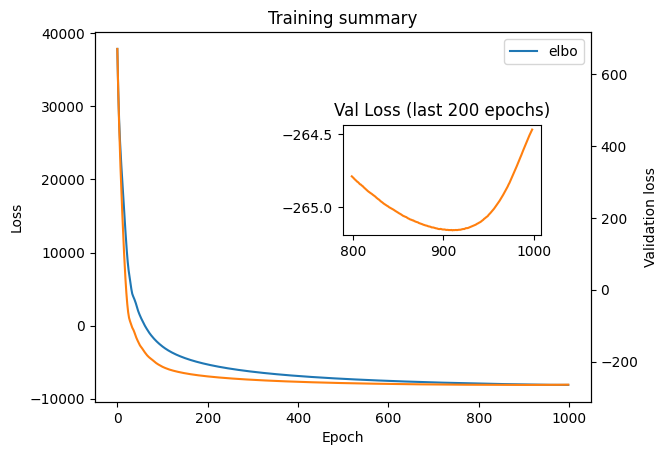

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(fit.train_loss, label="elbo")
if fit.validation_loss is not None:
    ax2 = ax.twinx()
    ax2.plot(fit.validation_loss, c="C1", label="neg log prob")
    ax2.set_ylabel("Validation loss")
ax.legend()

ax.set_title("Training summary")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

last_step = np.where(~np.isnan(fit.train_loss))[0].max() + 1
idx = np.arange(last_step - 200, last_step)
inset = ax.inset_axes([0.5, 0.45, 0.4, 0.3])
inset.plot(idx, fit.validation_loss[idx], "C1")
inset.set_title("Val Loss (last 200 epochs)")
plt.show()

## Sampling new fields

Next we show how to draw new fields after training. We trained a conditional
density estimator, so sampling in this context means drawing $p(y* | x*)$ for
a new $x*$. The Matern covariance function is well studied in spatial
statistics, particularly at half integer values, so we sample at this values.
Note these values were not part of the training or validation sets in general.

In [12]:
# NOTE: Generate samples from our model
key = jax.random.key(0)
xs = np.log([0.5, 1.0, 1.5, 2.0, 2.5])

model_samples = np.empty((len(xs), 5, train_data.samples.shape[-1]))
for j in range(len(xs)):
    model_samples[j] = jax.device_get(
        model.sample(jnp.array(xs[j]).reshape(1, 1), 5).squeeze()
    )

# Now reverse the maximin ordering
model_samples = model_samples[..., maxmin_ordering.argsort()]

Now we draw the same values from the data generating process for comparison.

In [13]:
# NOTE: Generate model samples aligned to the same values as the model samples are
data_samples = np.empty((len(xs), 5, train_data.samples.shape[-1]))
for i, xi in enumerate(xs):
    data_samples[i] = dgp.sample(5, nu=np.exp(xi))[0]

data_samples = data_samples[..., maxmin_ordering.argsort()]

Finally we can compare the data generating process (left) against the learned
model (right). We are comparing the samples in distribution, meaning that we
want to see qualitatively similar plots at a given value of $\nu$ in both
subplots. No individual fields will be identical in comparison, but overall
any column with fixed $\nu$ should be similar.

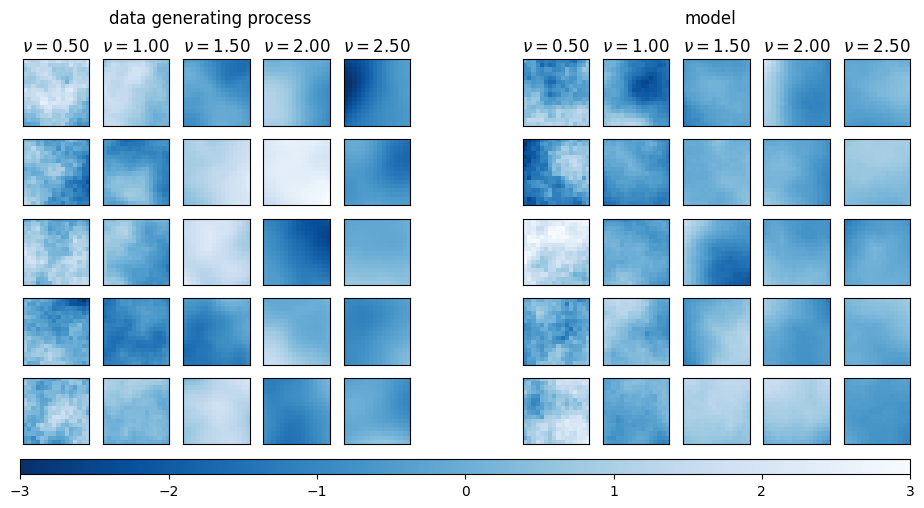

In [14]:
fig = plt.figure(figsize=(10, 5))
left, right = fig.subfigures(1, 2)
axl = left.subplots(5, len(xs))
axr = right.subplots(5, len(xs))
for j in range(len(xs)):
    axl[0, j].set_title(f"$\\nu=${np.exp(xs[j]):.2f}")
    axr[0, j].set_title(f"$\\nu=${np.exp(xs[j]):.2f}")
    for i in range(5):
        ms = data_samples[j, i].reshape(NLOCS, NLOCS)
        _ = axl[i, j].imshow(ms, cmap="Blues_r", vmin=-3, vmax=3)
        axl[i, j].set_xticks([])
        axl[i, j].set_yticks([])

        ms = model_samples[j, i].reshape(NLOCS, NLOCS)
        _ = axr[i, j].imshow(ms, cmap="Blues_r", vmin=-3, vmax=3)
        axr[i, j].set_xticks([])
        axr[i, j].set_yticks([])

cax = fig.add_axes([0.06, 0.05, 0.89, 0.03])
cbar = fig.colorbar(_, cax, orientation="horizontal")
left.suptitle("data generating process")
right.suptitle("model")
plt.show()

## Logscores

We conclude by demonstrating how to compute log scores (log probabilities).
The most obvious application of this is to investigate which covariate $x^*$
is compatible with a test field $y^*$. In the following code we generate a new
field $y^* | x^*$ using our data generating process and then compare $y^*$ to 
a grid of covariate values. This requires building a new `TMDataModule` object
with the gridded $x$ values and copies of the $y$ field that match dimensionally
with the grid of $x$ values. Then we can ues `CovariateTransportMap.logprob` to 
compute the new log probabilities.

In [15]:
nus = [0.5, 1.0, 1.5, 2.0, 2.5]
new_x = np.linspace(np.log(0.25), np.log(4.5), 73).reshape(-1, 1)
logprobs = []
for nu in nus:
    new_y = dgp.sample(n=1, nu=nu, seed=42)[0]
    new_y = np.stack([new_y for _ in range(new_x.shape[0])], axis=0).reshape(1, -1, NLOCS * NLOCS)

    score_data = jax.tree.map(
        lambda a: jax.device_put(a),
        [ locs[maxmin_ordering], nns, li, maxmin_ordering, new_x, new_y ],
    )
    score_data = Data(*score_data)
    # NOTE: Validation data uses a different instantiation method from training data
    score_module = build_data_module(score_data, sample_idx=0, max_nns=NNS)

    logprobs.append(model.logprob(score_module).sum(0))

In the previous code we generated new test sets with integer and half integer smoothness values 
$\nu = 0.5, \nu = 1.0, \nu = 1.5, \nu = 2.0, \nu = 2.5$. Then we built the `TMDataModule`
with a test field $y | \nu$ and a grid of $x = \log \nu$ values to search over. Finally we computed
log probabilities and appended the results to a list. Next we plot the results.

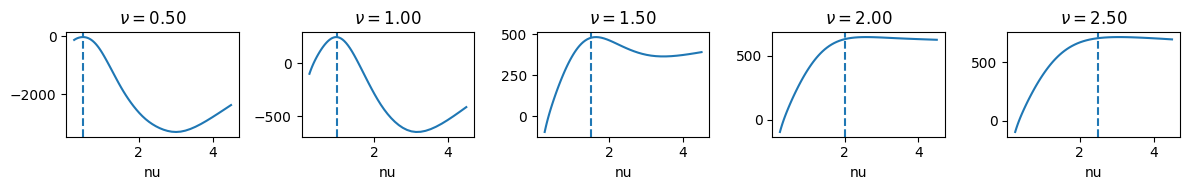

In [16]:
fig, ax = plt.subplots(1, len(nus), figsize=(12, 2))
for i, (nu, lp) in enumerate(zip(nus, logprobs)):
    ax[i].set_title(f"$\\nu=${nu:.2f}")
    ax[i].set_xlabel("nu")
    ax[i].plot(np.exp(new_x.squeeze()), lp)
    ax[i].axvline(x=nu, color=f'C{0}', linestyle='--')

fig.tight_layout()
plt.show()

In each subplot, the vertical line indicates the true value that a field was generated at.
The smooth curve indicates the model's log probability at each value of $\nu = \exp x$ in 
the grid search we defined. We can see that the model log probabilities are maximized at or
near the true covariate values, indicating the model can accurately discriminate values of the 
covariate after training.

## Appendix: Memory requirements

This method uses a large memory footprint and is computationally intensive,
so for this example we generate the data on a small spatial grid with 
`NLOCS = 16` evenly spaced points on each side of a unit square.
This works well for testing with a CPU-only installation of `jax`. 
When a GPU is present and training on real data, the datasets can become much
larger. 

We found in development it was useful to profile the memory using CPU
only instantiations to be sure a GPU could fit all of the parameters and data
for a training run. Note this requires inspecting the max memory use of every
method in the `CovariateTransportMap` object defined later; these are `fit`,
`sample`, and `logprob`. To reduce the memory footprint when doing inference
we implement the `sample` and `logprob` methods so that they convert data to 
numpy arrays (on the computer memory instead of device memory) whenever building
inference objects. The algorithms will use arrays allocated to accelerated devices
but only for the lifetime of the algorithm, then the results are put back in RAM.